In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 20

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -50
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 0  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 6 #10
NEGATIVE_REWARD_DIVIDE = 3 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0.7  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        
        self.learning_rate = 0.0009248
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


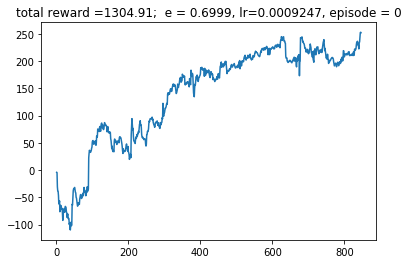

Waiting to train the whole dataset
action0:  478 
action1:  909 
action2:  593
DONE, lets roll!!
82.887


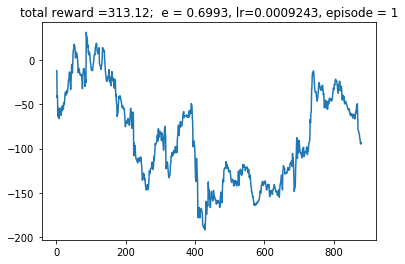

Waiting to train the whole dataset
action0:  465 
action1:  617 
action2:  898
DONE, lets roll!!
73.703


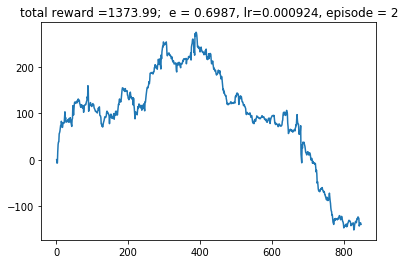

Waiting to train the whole dataset
action0:  447 
action1:  973 
action2:  560
DONE, lets roll!!
74.379


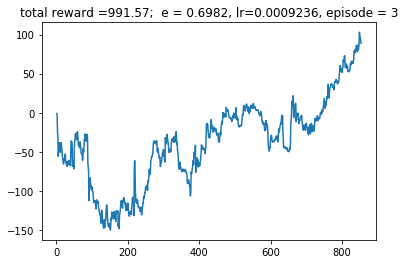

Waiting to train the whole dataset
action0:  455 
action1:  820 
action2:  705
DONE, lets roll!!
73.021


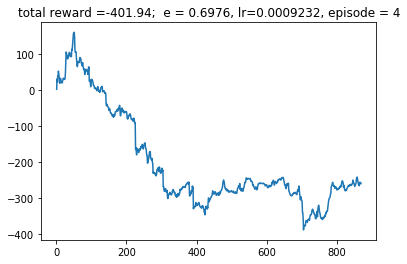

Waiting to train the whole dataset
action0:  461 
action1:  615 
action2:  904
DONE, lets roll!!
72.929


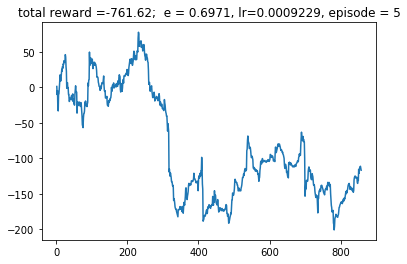

Waiting to train the whole dataset
action0:  499 
action1:  867 
action2:  614
DONE, lets roll!!
73.002


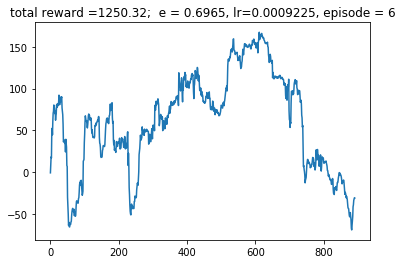

Waiting to train the whole dataset
action0:  450 
action1:  1044 
action2:  486
DONE, lets roll!!
73.217


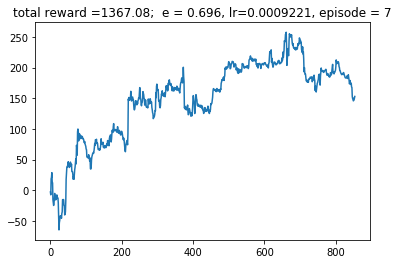

Waiting to train the whole dataset
action0:  475 
action1:  548 
action2:  957
DONE, lets roll!!
73.699


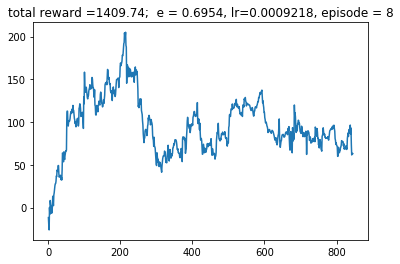

Waiting to train the whole dataset
action0:  448 
action1:  946 
action2:  586
DONE, lets roll!!
72.645


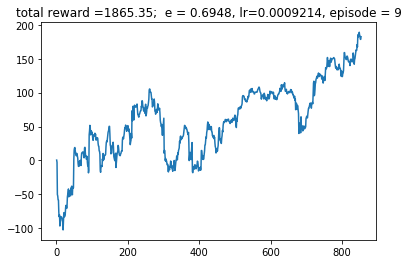

Waiting to train the whole dataset
action0:  463 
action1:  436 
action2:  1081
DONE, lets roll!!
73.221


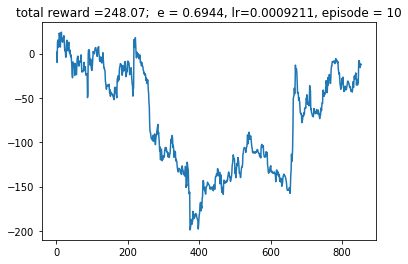

Waiting to train the whole dataset
action0:  471 
action1:  749 
action2:  760
DONE, lets roll!!
72.372


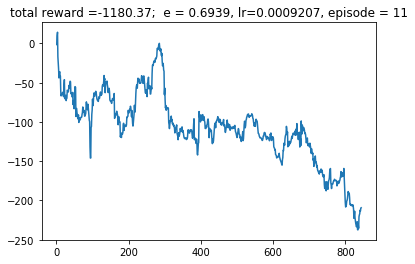

Waiting to train the whole dataset
action0:  482 
action1:  729 
action2:  769
DONE, lets roll!!
72.326


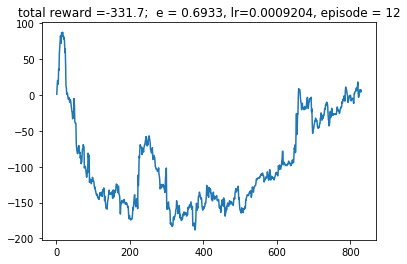

Waiting to train the whole dataset
action0:  479 
action1:  751 
action2:  750
DONE, lets roll!!
72.365


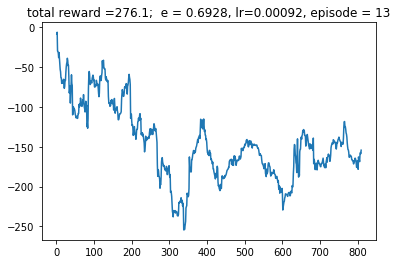

Waiting to train the whole dataset
action0:  461 
action1:  558 
action2:  961
DONE, lets roll!!
74.158


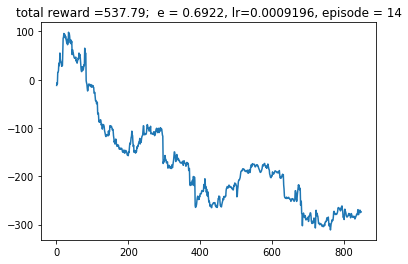

Waiting to train the whole dataset
action0:  461 
action1:  793 
action2:  726
DONE, lets roll!!
73.05


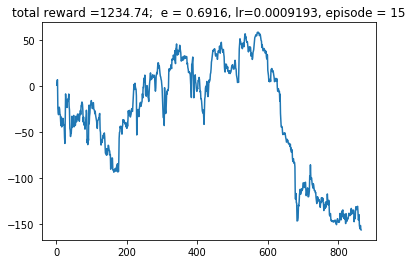

Waiting to train the whole dataset
action0:  425 
action1:  926 
action2:  629
DONE, lets roll!!
72.54


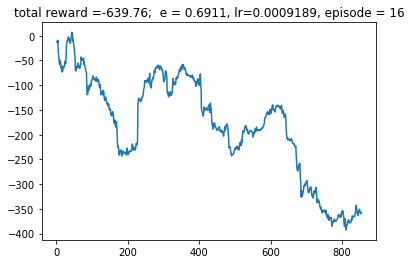

Waiting to train the whole dataset
action0:  475 
action1:  560 
action2:  945
DONE, lets roll!!
72.616


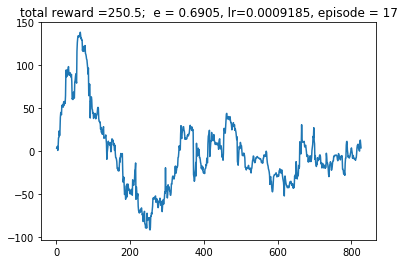

Waiting to train the whole dataset
action0:  435 
action1:  943 
action2:  602
DONE, lets roll!!
72.433


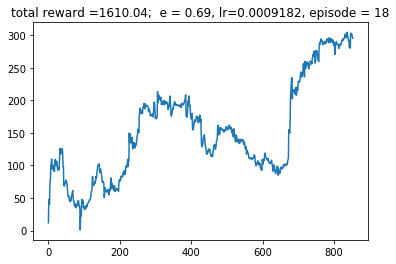

Waiting to train the whole dataset
action0:  475 
action1:  784 
action2:  721
DONE, lets roll!!
74.434


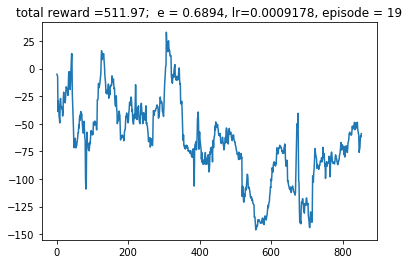

Waiting to train the whole dataset
action0:  452 
action1:  525 
action2:  1003
DONE, lets roll!!
73.051


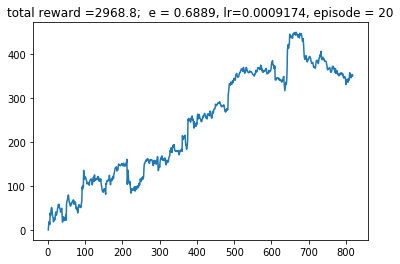

Waiting to train the whole dataset
action0:  444 
action1:  998 
action2:  538
DONE, lets roll!!
72.311


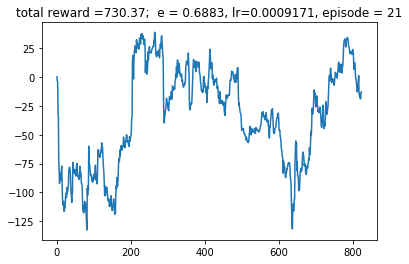

Waiting to train the whole dataset
action0:  432 
action1:  462 
action2:  1086
DONE, lets roll!!
73.258


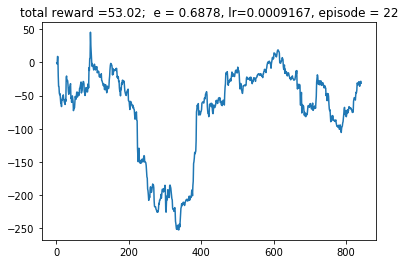

Waiting to train the whole dataset
action0:  476 
action1:  832 
action2:  672
DONE, lets roll!!
75.127


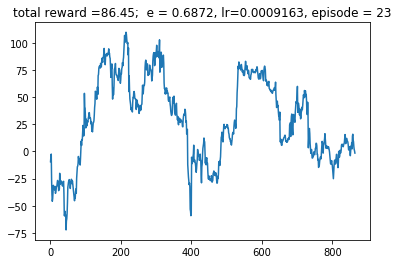

Waiting to train the whole dataset
action0:  461 
action1:  752 
action2:  767
DONE, lets roll!!
83.347


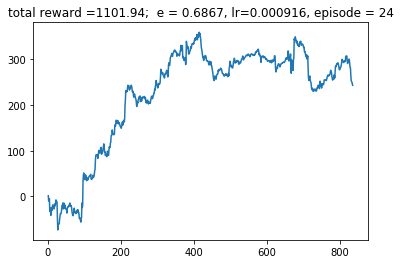

Waiting to train the whole dataset
action0:  479 
action1:  874 
action2:  627
DONE, lets roll!!
79.692


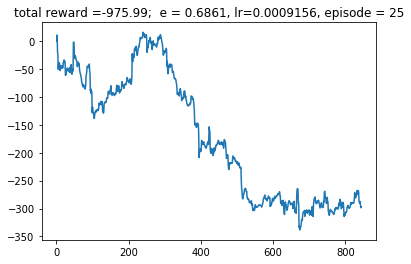

Waiting to train the whole dataset
action0:  483 
action1:  490 
action2:  1007
DONE, lets roll!!
83.638


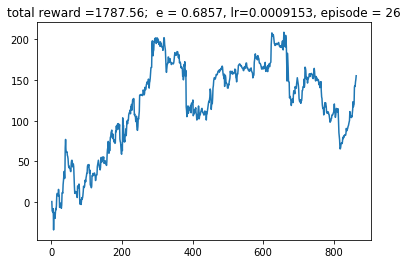

Waiting to train the whole dataset
action0:  451 
action1:  552 
action2:  977
DONE, lets roll!!
75.213


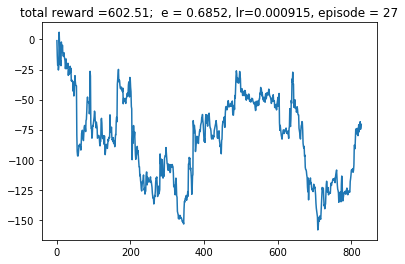

Waiting to train the whole dataset
action0:  430 
action1:  1087 
action2:  463
DONE, lets roll!!
73.537


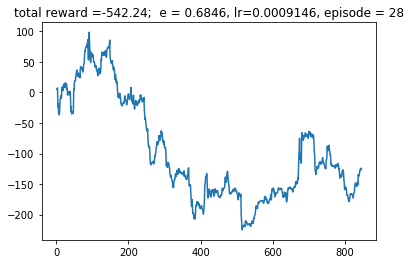

Waiting to train the whole dataset
action0:  441 
action1:  675 
action2:  864
DONE, lets roll!!
76.537


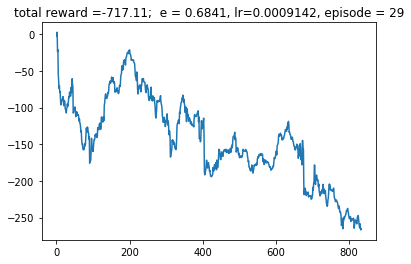

Waiting to train the whole dataset
action0:  444 
action1:  452 
action2:  1084
DONE, lets roll!!
76.936


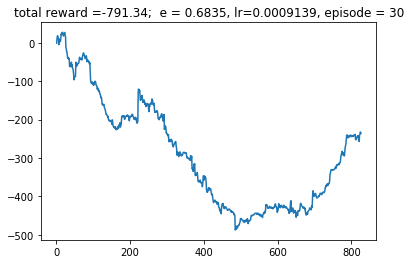

Waiting to train the whole dataset
action0:  438 
action1:  596 
action2:  946
DONE, lets roll!!
89.716


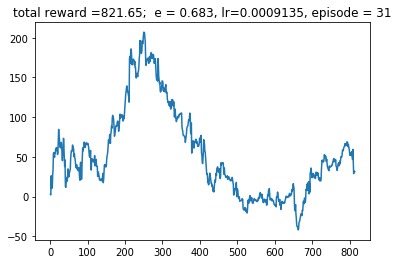

Waiting to train the whole dataset
action0:  459 
action1:  1064 
action2:  457
DONE, lets roll!!
81.374


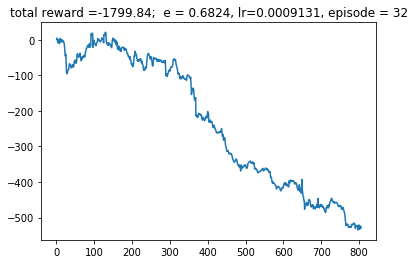

Waiting to train the whole dataset
action0:  452 
action1:  613 
action2:  915
DONE, lets roll!!
74.939


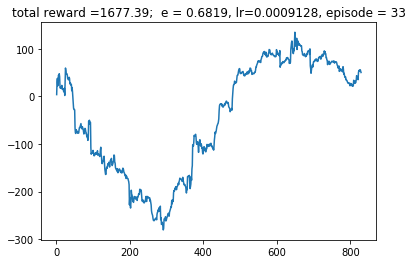

Waiting to train the whole dataset
action0:  471 
action1:  1029 
action2:  480
DONE, lets roll!!
75.714


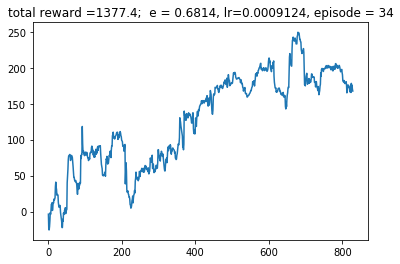

Waiting to train the whole dataset
action0:  467 
action1:  1053 
action2:  460
DONE, lets roll!!
72.784


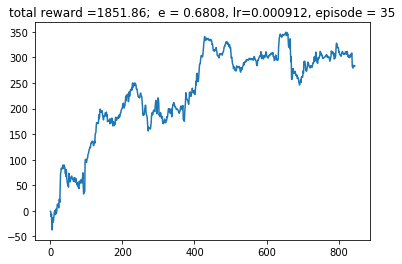

Waiting to train the whole dataset
action0:  451 
action1:  439 
action2:  1090
DONE, lets roll!!
73.294


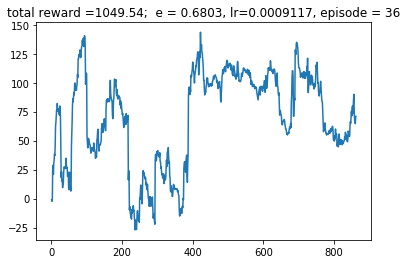

Waiting to train the whole dataset
action0:  467 
action1:  1023 
action2:  490
DONE, lets roll!!
80.157


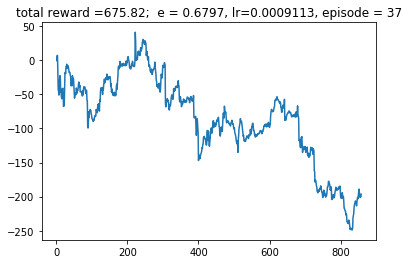

Waiting to train the whole dataset
action0:  440 
action1:  855 
action2:  685
DONE, lets roll!!
72.875


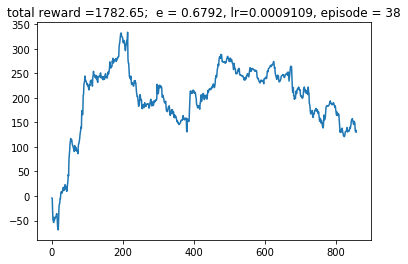

Waiting to train the whole dataset
action0:  444 
action1:  498 
action2:  1038
DONE, lets roll!!
75.599


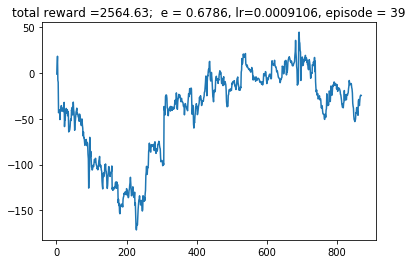

Waiting to train the whole dataset
action0:  424 
action1:  907 
action2:  649
DONE, lets roll!!
72.566


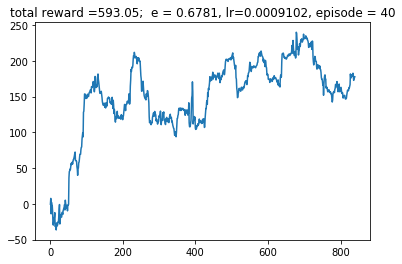

Waiting to train the whole dataset
action0:  458 
action1:  494 
action2:  1028
DONE, lets roll!!
73.686


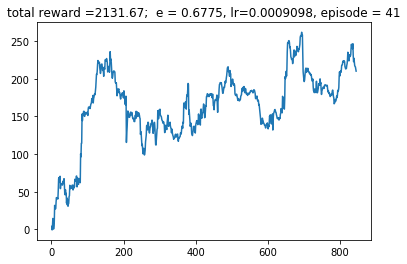

Waiting to train the whole dataset
action0:  428 
action1:  1074 
action2:  478
DONE, lets roll!!
83.111


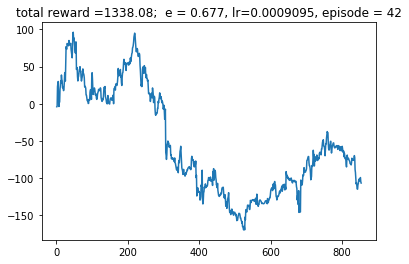

Waiting to train the whole dataset
action0:  439 
action1:  465 
action2:  1076
DONE, lets roll!!
82.475


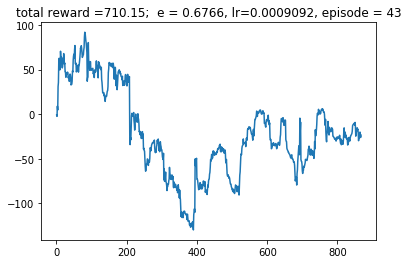

Waiting to train the whole dataset
action0:  468 
action1:  846 
action2:  666
DONE, lets roll!!
77.418


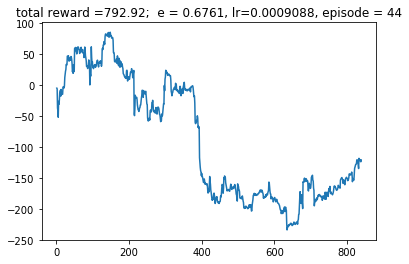

Waiting to train the whole dataset
action0:  441 
action1:  769 
action2:  770
DONE, lets roll!!
76.189


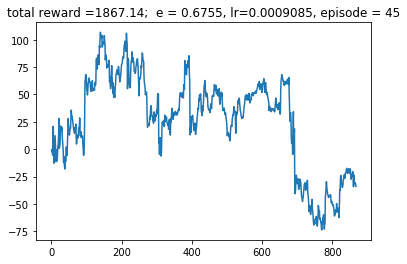

Waiting to train the whole dataset
action0:  434 
action1:  554 
action2:  992
DONE, lets roll!!
85.582


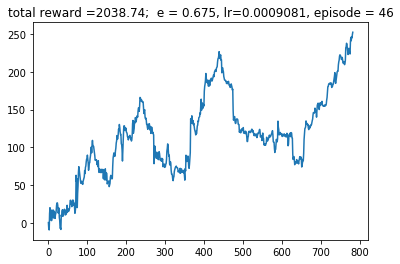

Waiting to train the whole dataset
action0:  447 
action1:  739 
action2:  794
DONE, lets roll!!
86.01


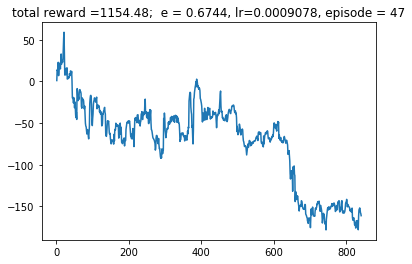

Waiting to train the whole dataset
action0:  453 
action1:  927 
action2:  600
DONE, lets roll!!
79.09


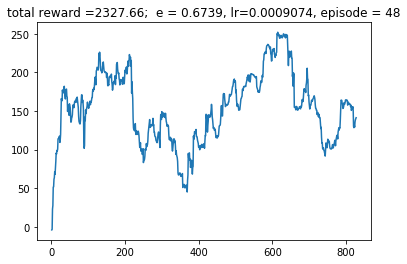

Waiting to train the whole dataset
action0:  441 
action1:  623 
action2:  916
DONE, lets roll!!
87.199


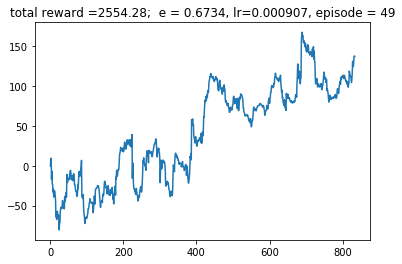

Waiting to train the whole dataset
action0:  471 
action1:  991 
action2:  518
DONE, lets roll!!
82.367


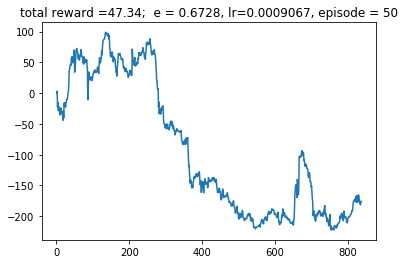

Waiting to train the whole dataset
action0:  442 
action1:  937 
action2:  601
DONE, lets roll!!
80.959


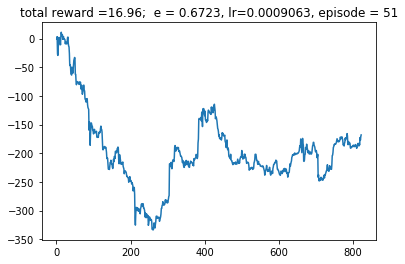

Waiting to train the whole dataset
action0:  440 
action1:  1103 
action2:  437
DONE, lets roll!!
84.577


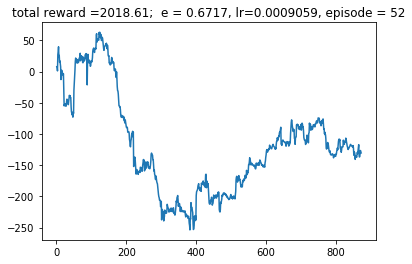

Waiting to train the whole dataset
action0:  407 
action1:  895 
action2:  678
DONE, lets roll!!
78.777


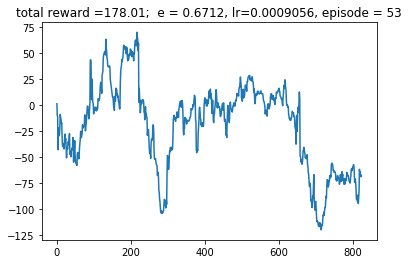

Waiting to train the whole dataset
action0:  438 
action1:  694 
action2:  848
DONE, lets roll!!
89.465


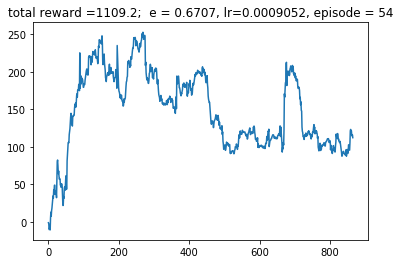

Waiting to train the whole dataset
action0:  431 
action1:  1055 
action2:  494
DONE, lets roll!!
87.423


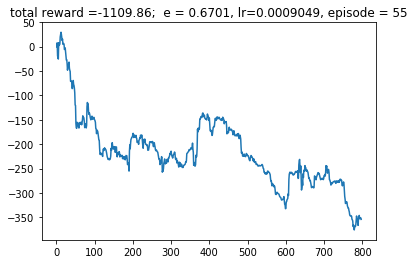

Waiting to train the whole dataset
action0:  448 
action1:  775 
action2:  757
DONE, lets roll!!
89.393


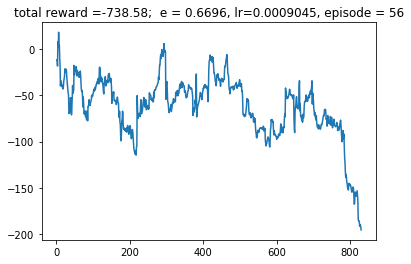

Waiting to train the whole dataset
action0:  437 
action1:  455 
action2:  1088
DONE, lets roll!!
95.89


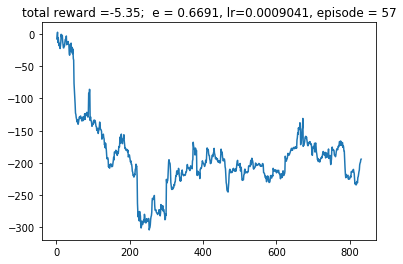

Waiting to train the whole dataset
action0:  468 
action1:  652 
action2:  860
DONE, lets roll!!
106.342


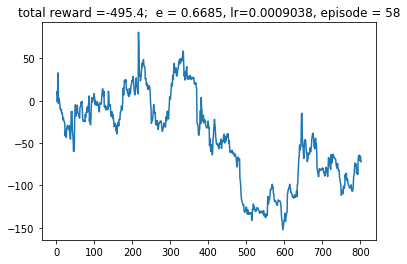

Waiting to train the whole dataset
action0:  443 
action1:  579 
action2:  958
DONE, lets roll!!
107.743


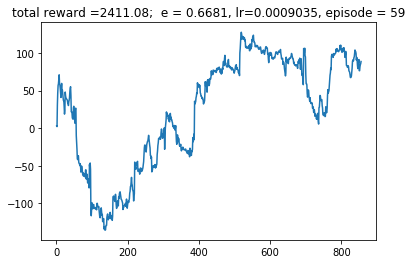

Waiting to train the whole dataset
action0:  445 
action1:  888 
action2:  647
DONE, lets roll!!
107.888


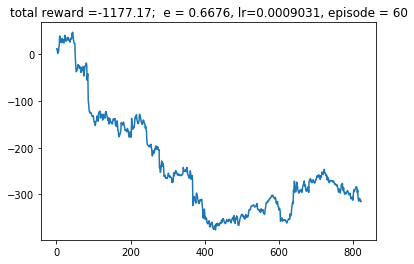

Waiting to train the whole dataset
action0:  451 
action1:  747 
action2:  782
DONE, lets roll!!
107.274


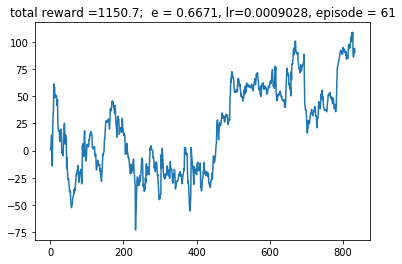

Waiting to train the whole dataset
action0:  468 
action1:  956 
action2:  556
DONE, lets roll!!
107.906


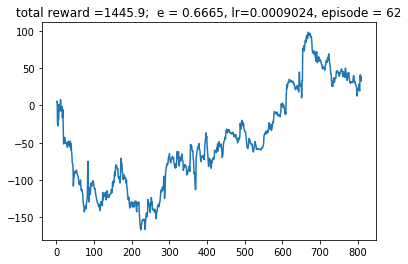

Waiting to train the whole dataset
action0:  448 
action1:  1102 
action2:  430
DONE, lets roll!!
108.725


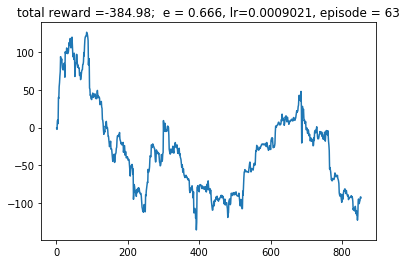

Waiting to train the whole dataset
action0:  482 
action1:  1064 
action2:  434
DONE, lets roll!!
90.569


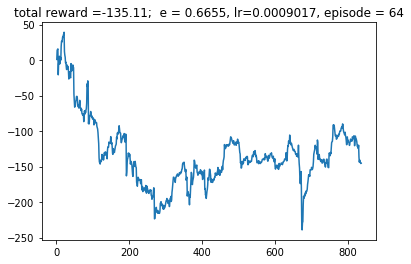

Waiting to train the whole dataset
action0:  445 
action1:  569 
action2:  966
DONE, lets roll!!
99.852


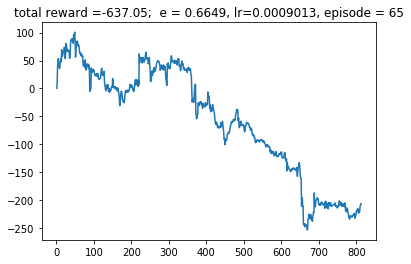

Waiting to train the whole dataset
action0:  461 
action1:  584 
action2:  935
DONE, lets roll!!
104.98


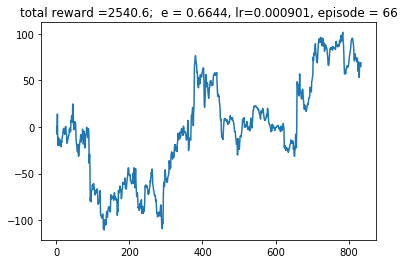

Waiting to train the whole dataset
action0:  434 
action1:  910 
action2:  636
DONE, lets roll!!
109.962


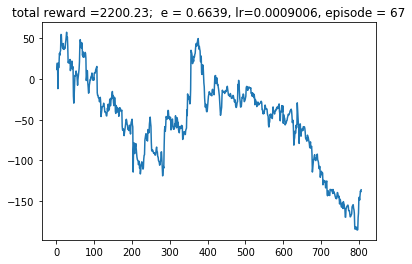

Waiting to train the whole dataset
action0:  400 
action1:  1016 
action2:  564
DONE, lets roll!!
110.764


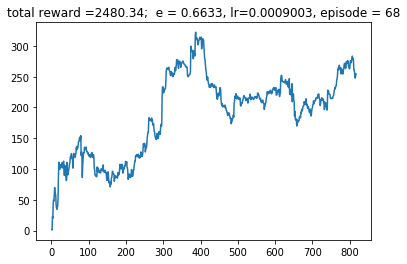

Waiting to train the whole dataset
action0:  417 
action1:  894 
action2:  669
DONE, lets roll!!
101.099


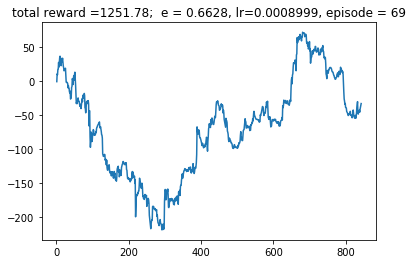

Waiting to train the whole dataset
action0:  427 
action1:  1104 
action2:  449
DONE, lets roll!!
87.628


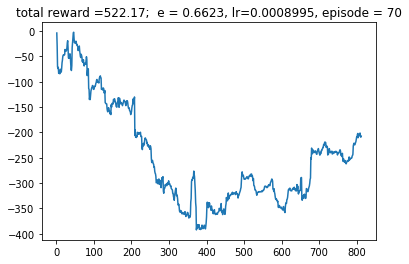

Waiting to train the whole dataset
action0:  448 
action1:  760 
action2:  772
DONE, lets roll!!
89.097


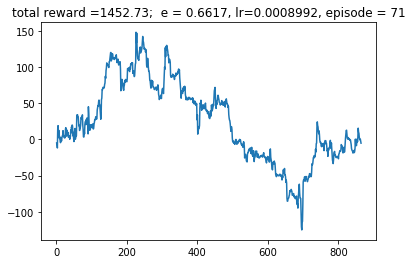

Waiting to train the whole dataset
action0:  449 
action1:  617 
action2:  914
DONE, lets roll!!
87.537


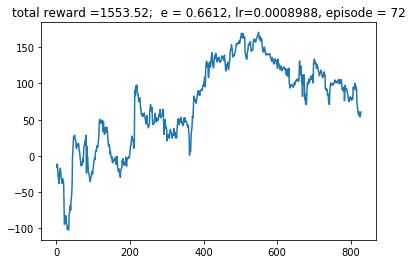

Waiting to train the whole dataset
action0:  429 
action1:  437 
action2:  1114
DONE, lets roll!!
89.856


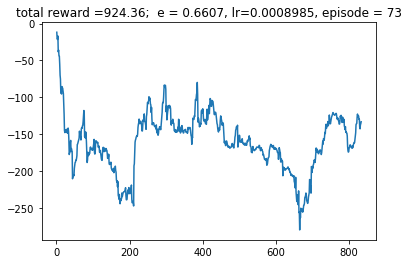

Waiting to train the whole dataset
action0:  410 
action1:  427 
action2:  1143
DONE, lets roll!!
105.36


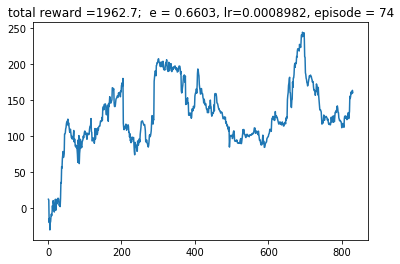

Waiting to train the whole dataset
action0:  439 
action1:  1081 
action2:  460
DONE, lets roll!!
94.824


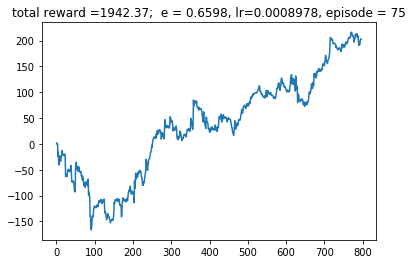

Waiting to train the whole dataset
action0:  429 
action1:  949 
action2:  602
DONE, lets roll!!
95.138


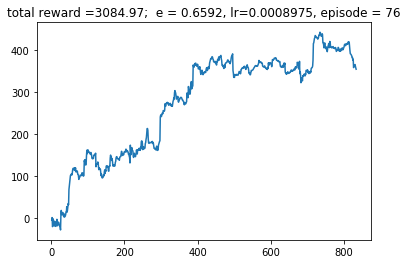

Waiting to train the whole dataset
action0:  424 
action1:  647 
action2:  909
DONE, lets roll!!
100.574


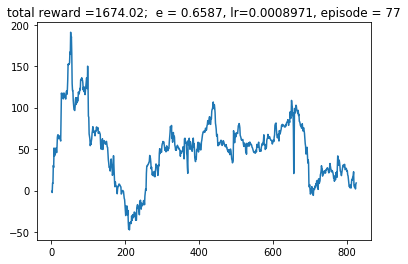

Waiting to train the whole dataset
action0:  444 
action1:  1103 
action2:  433
DONE, lets roll!!
97.289


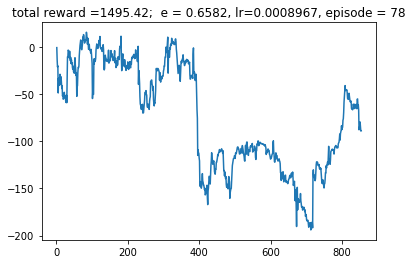

Waiting to train the whole dataset
action0:  425 
action1:  785 
action2:  770
DONE, lets roll!!
96.524


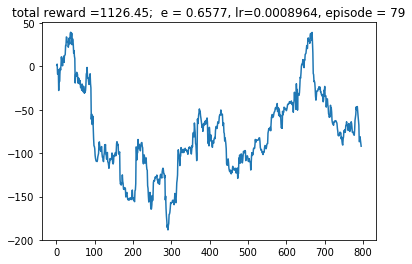

Waiting to train the whole dataset
action0:  391 
action1:  660 
action2:  929
DONE, lets roll!!
96.997


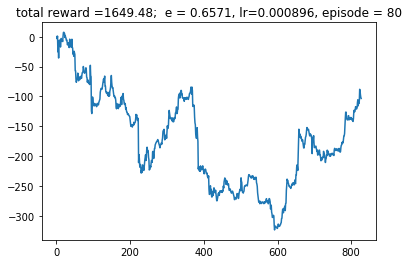

Waiting to train the whole dataset
action0:  413 
action1:  920 
action2:  647
DONE, lets roll!!
93.325


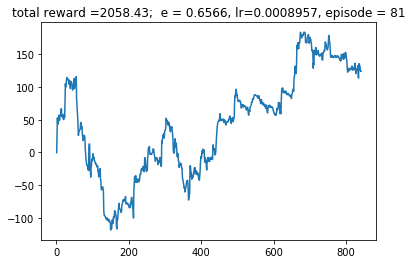

Waiting to train the whole dataset
action0:  407 
action1:  1073 
action2:  500
DONE, lets roll!!
92.055


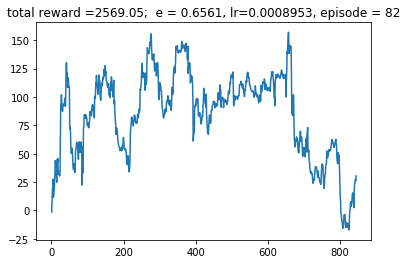

Waiting to train the whole dataset
action0:  414 
action1:  573 
action2:  993
DONE, lets roll!!
99.675


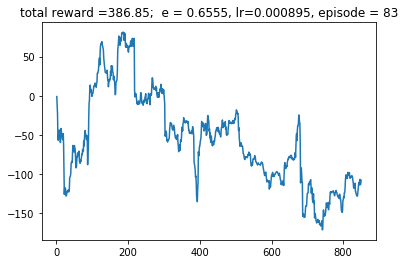

Waiting to train the whole dataset
action0:  451 
action1:  600 
action2:  929
DONE, lets roll!!
96.363


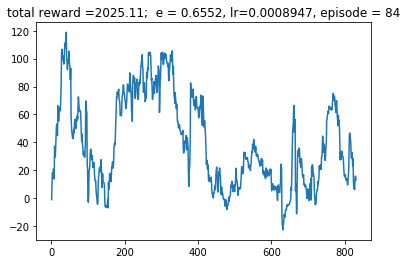

Waiting to train the whole dataset
action0:  419 
action1:  1113 
action2:  448
DONE, lets roll!!
98.258


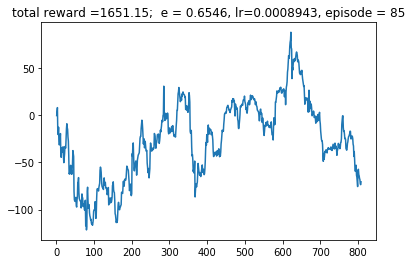

Waiting to train the whole dataset
action0:  412 
action1:  583 
action2:  985
DONE, lets roll!!
100.577


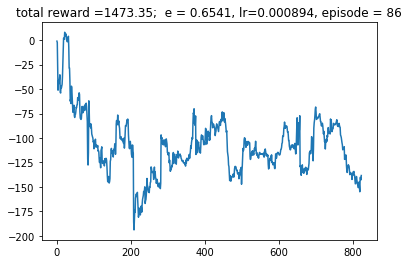

Waiting to train the whole dataset
action0:  386 
action1:  855 
action2:  739
DONE, lets roll!!
99.54


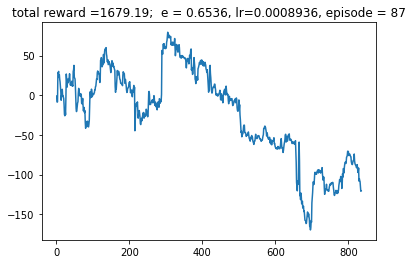

Waiting to train the whole dataset
action0:  420 
action1:  887 
action2:  673
DONE, lets roll!!
108.132


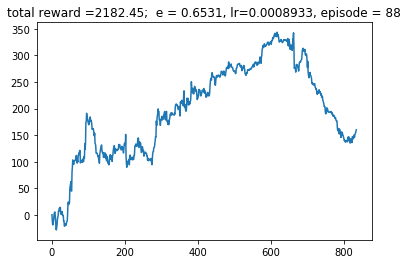

Waiting to train the whole dataset
action0:  418 
action1:  636 
action2:  926
DONE, lets roll!!
106.093


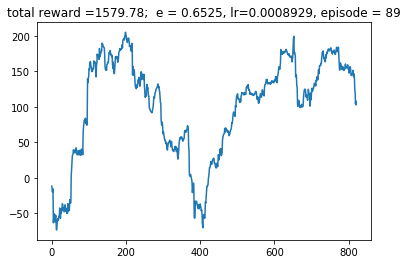

Waiting to train the whole dataset
action0:  450 
action1:  414 
action2:  1116
DONE, lets roll!!
101.872


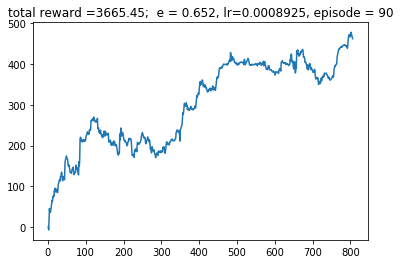

Waiting to train the whole dataset
action0:  400 
action1:  825 
action2:  755
DONE, lets roll!!
92.965


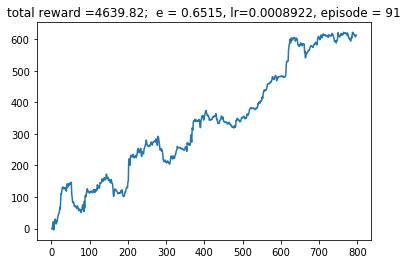

Waiting to train the whole dataset
action0:  411 
action1:  774 
action2:  795
DONE, lets roll!!
92.887


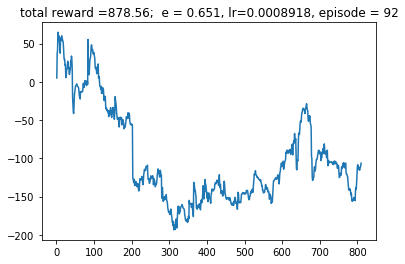

Waiting to train the whole dataset
action0:  429 
action1:  1133 
action2:  418
DONE, lets roll!!
95.264


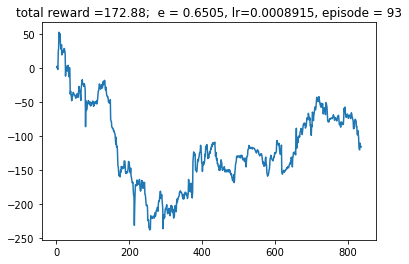

Waiting to train the whole dataset
action0:  437 
action1:  809 
action2:  734
DONE, lets roll!!
94.809


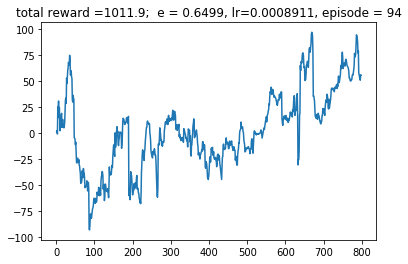

Waiting to train the whole dataset
action0:  436 
action1:  991 
action2:  553
DONE, lets roll!!
86.304


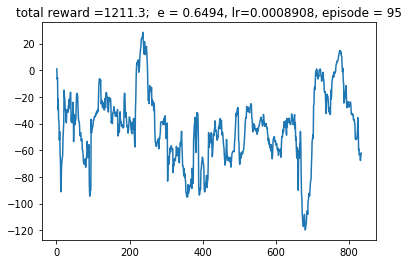

Waiting to train the whole dataset
action0:  425 
action1:  444 
action2:  1111
DONE, lets roll!!
93.878


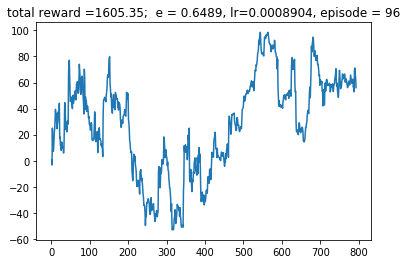

Waiting to train the whole dataset
action0:  440 
action1:  973 
action2:  567
DONE, lets roll!!
83.889


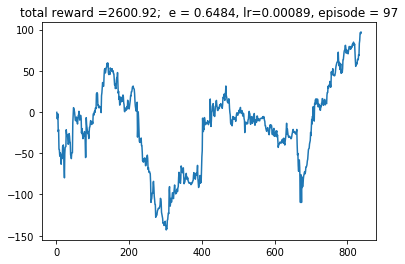

Waiting to train the whole dataset
action0:  432 
action1:  417 
action2:  1131
DONE, lets roll!!
83.622


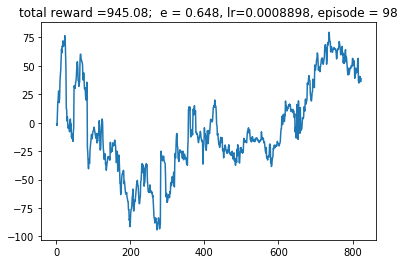

Waiting to train the whole dataset
action0:  438 
action1:  916 
action2:  626
DONE, lets roll!!
85.758


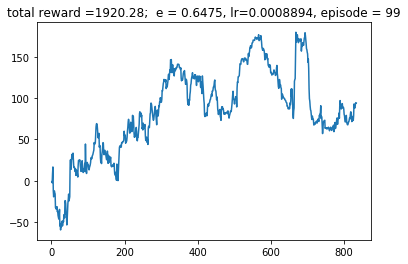

Waiting to train the whole dataset
action0:  422 
action1:  864 
action2:  694
DONE, lets roll!!
86.9


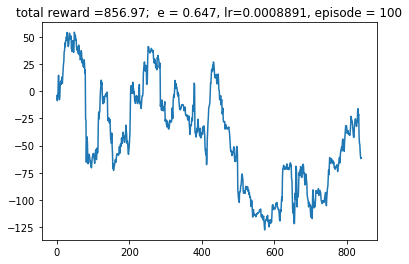

Waiting to train the whole dataset
action0:  437 
action1:  532 
action2:  1011
DONE, lets roll!!
86.409


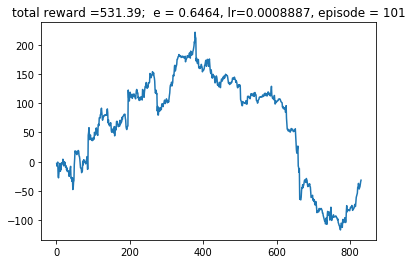

Waiting to train the whole dataset
action0:  443 
action1:  612 
action2:  925
DONE, lets roll!!
84.217


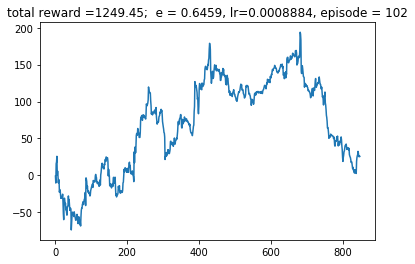

Waiting to train the whole dataset
action0:  425 
action1:  686 
action2:  869
DONE, lets roll!!
86.841


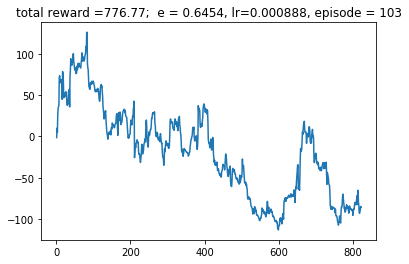

Waiting to train the whole dataset
action0:  455 
action1:  1075 
action2:  450
DONE, lets roll!!
85.98


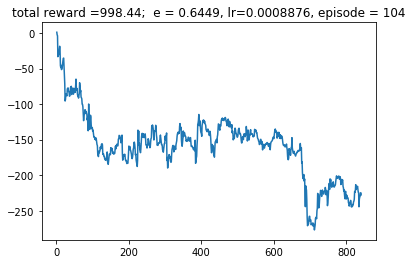

Waiting to train the whole dataset
action0:  431 
action1:  427 
action2:  1122
DONE, lets roll!!
84.433


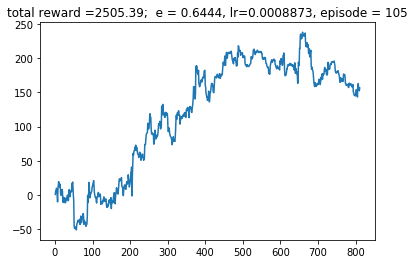

Waiting to train the whole dataset
action0:  420 
action1:  1135 
action2:  425
DONE, lets roll!!
83.928


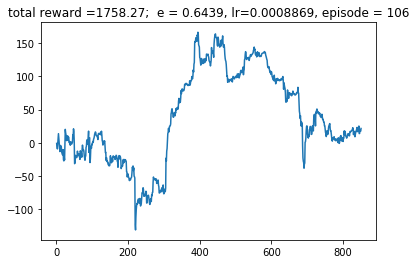

Waiting to train the whole dataset
action0:  436 
action1:  868 
action2:  676
DONE, lets roll!!
83.943


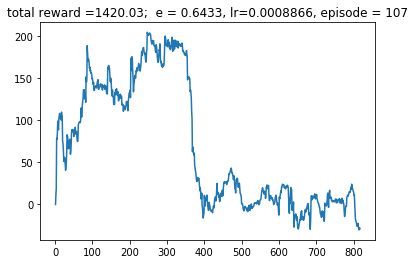

Waiting to train the whole dataset
action0:  426 
action1:  982 
action2:  572
DONE, lets roll!!
83.837


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))